In [1]:
import io
import tarfile
from collections import defaultdict
from pathlib import Path

import numpy as np

from ugradiolab import Record, Spectrum

HI_FREQ = 1420.405751768  # MHz

SRC = 'data/lab2_galactic_obs.tar.gz'

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
data = defaultdict(list)
with tarfile.open(SRC, 'r:gz') as tar:
    for m in tar:
        if not (m.isfile() and m.name.endswith('.npz')):
            continue
        f = tar.extractfile(m)
        if f is None:
            continue
        buf = f.read()
        if not buf:
            continue  # skip corrupt/empty members
        key = Path(m.name).stem.rsplit('_', 3)[0]
        data[key].append(Record.load(io.BytesIO(buf)))

for records in data.values():
    records.sort(key=lambda r: r.unix_time)

total = sum(len(v) for v in data.values())
print(f'Loaded {total} records')
for k in sorted(data):
    print(f'  {k}: {len(data[k])}')

Loaded 11 records
  GAL-A: 6
  GAL-B: 5


In [3]:
spectra = {key: [Spectrum.from_record(r) for r in records]
           for key, records in data.items()}

for key, specs in sorted(spectra.items()):
    print(f'{key}: {len(specs)} spectra, '
          f'freqs {specs[0].freqs_mhz[0]:.3f}–{specs[0].freqs_mhz[-1]:.3f} MHz')

GAL-A: 6 spectra, freqs 1418.720–1421.280 MHz
GAL-B: 5 spectra, freqs 1419.720–1422.280 MHz


In [4]:
for key in sorted(spectra):
    for i, spec in enumerate(spectra[key]):
        r = spec.record
        bw = r.sample_rate / 1e6
        print(f'{key}[{i}]  sample_rate={r.sample_rate/1e6:.3f} MHz  '
              f'nsamples={r.nsamples}  center={r.center_freq/1e6:.3f} MHz  '
              f'span=[{spec.freqs_mhz[0]:.3f}, {spec.freqs_mhz[-1]:.3f}] MHz')

GAL-A[0]  sample_rate=2.560 MHz  nsamples=32768  center=1420.000 MHz  span=[1418.720, 1421.280] MHz
GAL-A[1]  sample_rate=2.560 MHz  nsamples=32768  center=1420.000 MHz  span=[1418.720, 1421.280] MHz
GAL-A[2]  sample_rate=2.560 MHz  nsamples=32768  center=1420.000 MHz  span=[1418.720, 1421.280] MHz
GAL-A[3]  sample_rate=2.560 MHz  nsamples=32768  center=1420.000 MHz  span=[1418.720, 1421.280] MHz
GAL-A[4]  sample_rate=2.560 MHz  nsamples=32768  center=1420.000 MHz  span=[1418.720, 1421.280] MHz
GAL-A[5]  sample_rate=2.560 MHz  nsamples=32768  center=1420.000 MHz  span=[1418.720, 1421.280] MHz
GAL-B[0]  sample_rate=2.560 MHz  nsamples=32768  center=1421.000 MHz  span=[1419.720, 1422.280] MHz
GAL-B[1]  sample_rate=2.560 MHz  nsamples=32768  center=1421.000 MHz  span=[1419.720, 1422.280] MHz
GAL-B[2]  sample_rate=2.560 MHz  nsamples=32768  center=1421.000 MHz  span=[1419.720, 1422.280] MHz
GAL-B[3]  sample_rate=2.560 MHz  nsamples=32768  center=1421.000 MHz  span=[1419.720, 1422.280] MHz


/tmp/ipykernel_62362/2499050125.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


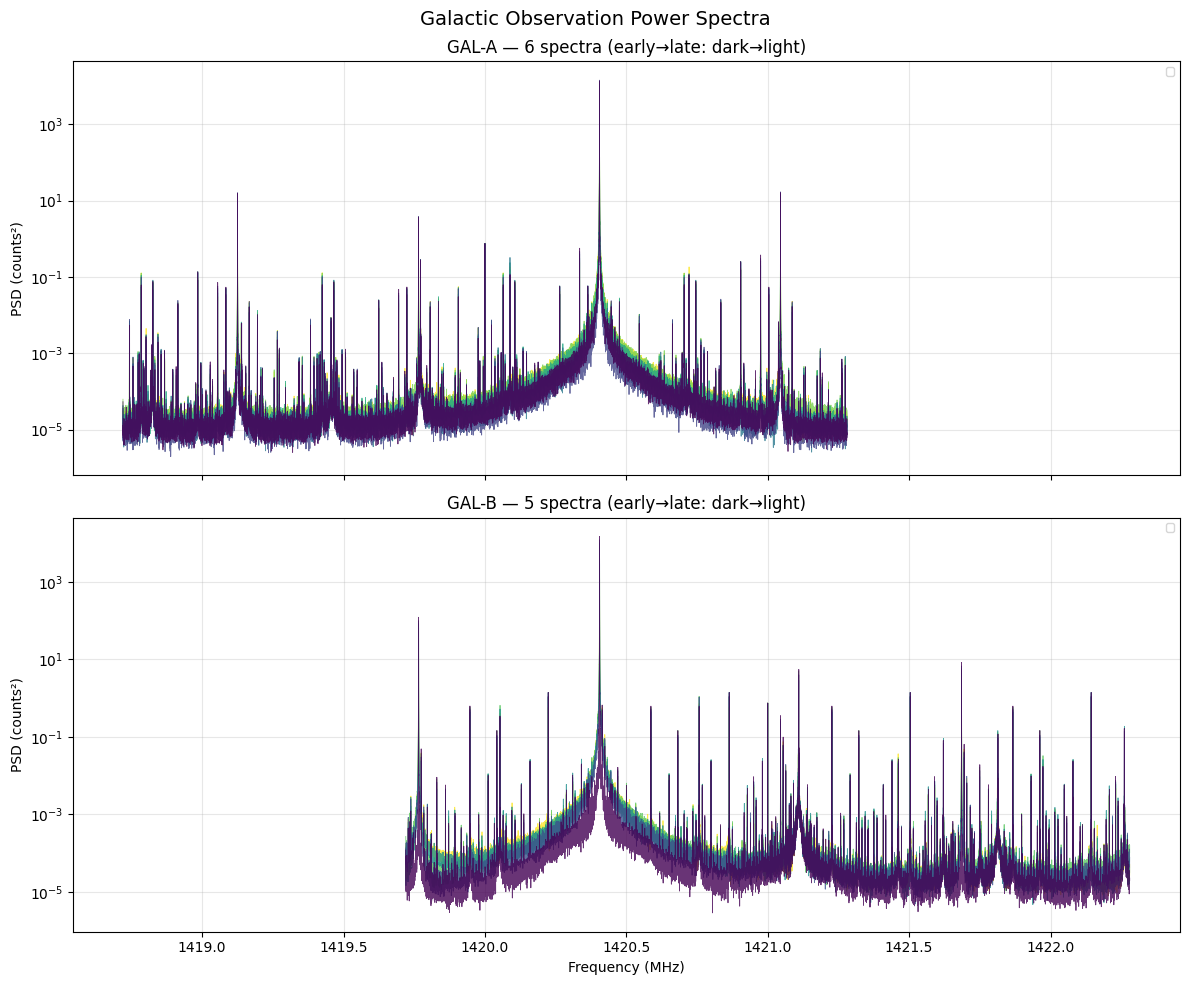

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

keys = sorted(spectra)
fig, axes = plt.subplots(len(keys), 1, figsize=(12, 5 * len(keys)), sharex=True)
axes = [axes] if len(keys) == 1 else list(axes)

for ax, key in zip(axes, keys):
    specs = spectra[key]
    colors = cm.viridis_r(np.linspace(0, 1, len(specs)))
    for spec, color in zip(specs, colors):
        ax.semilogy(spec.freqs_mhz, spec.psd, lw=0.6, alpha=0.8, color=color)
    # ax.axvline(HI_FREQ, color='red', ls='--', lw=1.0, label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.set_ylabel('PSD (counts²)')
    ax.set_title(f'{key} — {len(specs)} spectra (early→late: dark→light)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('Galactic Observation Power Spectra', fontsize=14)
plt.tight_layout()
plt.show()